In [213]:
import json
import pandas as pd
import numpy as np
import pymongo
import os.path
import seaborn as sns
import re
import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook, tqdm_pandas
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn import preprocessing, metrics
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression

tqdm_notebook().pandas()
sns.set_context('talk')
sns.set_style('whitegrid')

%matplotlib inline

# Load data

## Control and treatment groups

###  Load users information

In [2]:
n_users = pd.read_csv("./nosport_users_stats")
s_users = pd.read_csv("./sport_users_stats")

for df in [n_users, s_users]:
    df.index = df['id']

In [3]:
s_users.shape, n_users.shape

((1160, 7), (1160, 7))

### Load matches

Load matches file.

In [4]:
matches = pd.read_csv("/data/1/sporty/users/classification/matches.txt", header=None, names=['sport', 'nosport'])

Some users have been matched twice to a sport users, we remove these duplicate entries here although we missed them in 2014.

In [5]:
matches = matches.drop_duplicates(subset=['nosport'])
n_users = n_users.drop_duplicates(subset=['id'])

Align users' dataframes.

In [6]:
s_users = s_users.loc[matches.sport.tolist()]
s_users.index = np.arange(s_users.shape[0])
n_users = n_users.loc[matches.nosport.tolist()]
n_users.index = np.arange(n_users.shape[0])

In [7]:
s_users.shape, n_users.shape

((1153, 7), (1153, 7))

Remove users that are in both groups and their match that we missed last time.

In [8]:
# find users in both groups
both_groups = set(s_users['id']) & set(n_users['id'])

# find lines with users in both groups
s_idx_to_remove = s_users.id.where(s_users.id.apply(lambda _: _ in both_groups)).dropna().index.tolist()
n_idx_to_remove = n_users.id.where(n_users.id.apply(lambda _: _ in both_groups)).dropna().index.tolist()
idx_to_remove = s_idx_to_remove + n_idx_to_remove

# remove lines from users' dataframes
s_users = s_users.drop(idx_to_remove, axis=0)
n_users = n_users.drop(idx_to_remove, axis=0)

In [9]:
s_users.shape, n_users.shape

((1137, 7), (1137, 7))

### Load tweets for each user 

In [51]:
def load_tweets(user_id, data_dir, remove_hash=None, keep_rt=False):
    user_p = os.path.join(data_dir, user_id)
    tweets = []
    with open(user_p) as fd:
        for l in fd:
            o = json.loads(l)
            # check for retweets
            if not keep_rt and 'retweeted_status' in o:
                keep_tw = False
            else:
                # check for hashtags to avoid
                h = set([_['text'].lower() for _ in o['entities']['hashtags']])
                keep_tw = remove_hash is None or not (h & set(remove_hash))
            
            if keep_tw:
                tweets.append(o['text'])
    return tweets
    
auto_hash = ['runkeeper', 'nikeplus', 'runtastic', 'endomondo', 'mapmyrun', 'strava', 'cyclemeter', 'fitstats', 'mapmyfitness', 'runmeter']

def load_tweets_sport(user_id):
    return load_tweets(user_id, "/data/1/sporty/tweets/from_users/sport/", remove_hash=auto_hash)
    
def load_tweets_nosport(user_id):
    return load_tweets(user_id, "/data/1/sporty/tweets/from_users/no_sport/", remove_hash=auto_hash)

In [60]:
s_users['tweets'] = s_users.id.astype(str).progress_apply(load_tweets_sport)
n_users['tweets'] = n_users.id.astype(str).progress_apply(load_tweets_nosport)

In [75]:
s_users['tweets_count'] = s_users.tweets.apply(len)
n_users['tweets_count'] = n_users.tweets.apply(len)

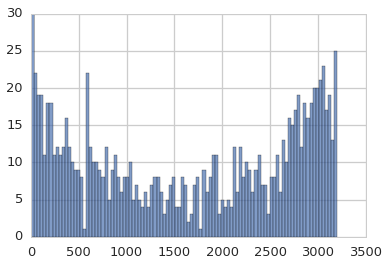

In [76]:
n_users[n_users.tweets_count>0].tweets_count.hist(bins=100,alpha=0.7)

In [82]:
(n_users.tweets_count <= 20).sum()

125

## Mood annotated data

In [86]:
def load_labeled_mood(p):
    tweets = []
    with open(p) as fd:
        for l in tqdm_notebook(fd):
            o = json.loads(l)
            tweets.append({k: o[k] for k in ['text', 'AH', 'DD', 'TA']})
    return pd.DataFrame(tweets)

mood_tweets_df = load_labeled_mood("/data/1/sporty/tweets/labeled/3K_labeled")

### Load LIWC lexicon

In [91]:
''' Data structure and utility functions for reading and querying a LIWC
lexicon. Data described here:
http://homepage.psy.utexas.edu/homepage/faculty/pennebaker/reprints/LIWC2001.pdf
'''

from collections import defaultdict
import os


class Lexicon(object):
    """
    >>> import tempfile
    >>> tf = tempfile.NamedTemporaryFile()
    >>> tf.write("%\\n1\\tPronoun\\n2\\tI\\n3\tGreet\\n%\\ni\\t01 02\\nhis\\t01\\nhi*\t03")
    >>> tf.flush()
    >>> d = Lexicon(tf.name)
    >>> d.categories_for_tokens(['i', 'his'])
    [[u'Pronoun', u'I'], [u'Pronoun']]
    >>> d.categories_for_tokens(['his'])
    [[u'Pronoun']]
    >>> cts = d.counts_for_tokens(['i', 'his'])
    >>> cts[u'I']
    1
    >>> cts[u'Pronoun']
    2
    >>> d.categories_for_tokens(['zebra'])
    [[]]
    >>> d.categories_for_tokens(['hithere'])
    [[u'Greet']]
    """

    def __init__(self, dict_file=None):
        self.dict_file = dict_file
        self.load_dictionary(dict_file)

    def parse_categories(self, catText):
        lines = catText.split("\n")
        self.categories = {}
        for line in lines:
            if len(line) > 0:
                key, val = line.split()
                self.categories[str(key)] = str(val)

    def parse_patterns(self, regExps):
        lines = regExps.split("\n")
        self.exact_patterns = {}
        self.prefix_patterns = {}
        for line in lines:
            if len(line) > 0 and not line.startswith('//'):
                vals = line.split()
                exp = vals[0]
                ids = [str(int(v)) for v in vals[1:]]
                if '*' in exp:
                    self.prefix_patterns[exp[:-1]] = ids
                else:
                    self.exact_patterns[exp] = ids

    def load_dictionary(self, dict_file):
        dict_text = open(dict_file).read()
        as_list = dict_text.split("%")
        self.parse_categories(as_list[1])
        self.parse_patterns(as_list[2])

    def categories_for_token(self, word):
        result = []
        if word in self.exact_patterns:
            result.extend(self.exact_patterns[word])
        else:
            for i in range(0, len(word)):
                if word[:-i] in self.prefix_patterns:
                    result.extend(self.prefix_patterns[word[:-i]])
        return [self.categories[c] for c in result]

    def categories_for_tokens(self, tokens):
        """ Returns a list of lists. For each token, create a list of categories
        it belongs to."""
        return [self.categories_for_token(token) for token in tokens]

    def counts_for_tokens(self, tokens):
        """ Returns a dict mapping categories to counts from this list of
        tokens. """
        cats = self.categories_for_tokens(tokens)
        d = defaultdict(lambda: 0)
        for a in cats:
            for b in a:
                d[b] += 1
        return d
    
lex = Lexicon("./liwc.dic")

###  Load emoticons 

In [115]:
emoticon_df = pd.read_csv("emoticons", sep=" ", header=None, names=['tag', 'emoticon'], index_col=1)
emoticon_dict = emoticon_df.to_dict(orient='dict')['tag']

###  Build features encoding

Build tokenizer

In [289]:
def tokenize(text, collapse_hashtags=True, collapse_mentions=True, collapse_urls=True, collapse_digits=True, limit_repeats=True):    
    text = re.sub("\s+", " ", text.lower())
    if collapse_hashtags:
        text = re.sub('#\S+', 'THIS_IS_A_HASHTAG', text)
    else:
        text = re.sub('#(\S+)', r'HASHTAG_\1', text)
    if collapse_mentions:
        text = re.sub('@\S+', 'THIS_IS_A_MENTION', text)
    if collapse_urls:
        text = re.sub('http\S+', 'THIS_IS_A_URL', text)
    if limit_repeats:
        text = re.sub(r'(.)\1\1\1+', r'\1', text)
    if collapse_digits:
        text = re.sub(r'[0-9]+', '9', text)
    splits = text.split()
    tokens = []
    liwc_tokens = []
    for tok in splits:
        if tok in emoticon_dict:
            tokens.append(emoticon_dict[tok])
        else:
            tokens.append(tok)
        liwc_tokens.extend(["LIWC_" + _ for _ in lex.categories_for_token(tok)])
    liwc_tokens = list(set(liwc_tokens))
    return tokens + liwc_tokens

Pipeline of vectorizer and features selection.

Apply to 3 mood dimensions.

In [302]:
moods = ['AH', 'DD', 'TA']
vecs = {}
kbests = {}
plines = {}
Xs = {}
clfs = {}
features = {}
top_features = {}

for m in tqdm_notebook(moods):
    # build pipeline
    vecs[m] = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1,2))
    kbests[m] = SelectKBest(chi2, 160)
    plines[m] = pipeline = Pipeline([('tfidf', vecs[m]), ('chi2', kbests[m])])
    
    # build doc term matrix
    y = mood_tweets_df[m]
    Xs[m] = plines[m].fit_transform(mood_tweets_df.text, y)
    Xs[m] = preprocessing.scale(Xs[m].toarray())
    # get labels

    # train classifier
    clfs[m] = LogisticRegression(class_weight='balanced')
    clfs[m].fit(Xs[m],y)
    
    # retrieve features
    support = kbests[m].get_support()
    features[m] = np.array(vecs[m].get_feature_names())[support]
    top_features[m] = [(features[m][i], clfs[m].coef_[0][i]) for i in clfs[m].coef_[0].argsort()[::-1]]

In [303]:
for m in moods:
    print("Top features for", m)
    for i, (w,c) in enumerate(top_features[m][:20]):
        print("{}. {:<40}{:>8}".format(i, w, "%.3f" % c))
    print('-'*100)

Top features for AH
0. LIWC_Anger                                 0.879
1. upset                                      0.386
2. hate                                       0.364
3. beyond irritated                           0.350
4. that shit                                  0.348
5. fucking irritated                          0.331
6. why would                                  0.289
7. they use                                   0.284
8. irritated LIWC_I                           0.280
9. ur a                                       0.271
10. THIS_IS_A_MENTION stupid                   0.269
11. miserable LIWC_Negemo                      0.269
12. LIWC_Affect LIWC_Swear                     0.266
13. LIWC_Swear LIWC_Feel                       0.264
14. fucking                                    0.260
15. shit                                       0.256
16. rude                                       0.254
17. ignorant                                   0.253
18. so mad                          

Cross validation

In [304]:
def cv(data, n_folds=10):
    results = {}

    for m in tqdm_notebook(moods):
        y_probs = []
        y_preds = []
        y_trues = []
        for tr, te in tqdm_notebook(KFold(data.shape[0], n_folds, shuffle=True, random_state=123456)):
            data_tr, data_te = data.iloc[tr], data.iloc[te]
            y_tr, y_te = data_tr[m], data_te[m]
            X_tr = plines[m].fit_transform(data_tr.text, y_tr)
            X_tr = preprocessing.scale(X_tr.toarray())

            X_te = plines[m].transform(data_te.text)
            X_te = preprocessing.scale(X_te.toarray())

            clf = LogisticRegression(class_weight='balanced')
            clf.fit(X_tr, y_tr)
            y_prob = clf.predict_proba(X_te)[:,1]
            y_pred = clf.predict(X_te)

            y_trues.extend(y_te)
            y_preds.extend(y_pred)
            y_probs.extend(y_prob)
    
        results[m] = {'y_true': y_trues, 'y_pred': y_preds, 'y_prob': y_probs}
    return results

In [ ]:
results_cv = cv(mood_tweets_df, 10)

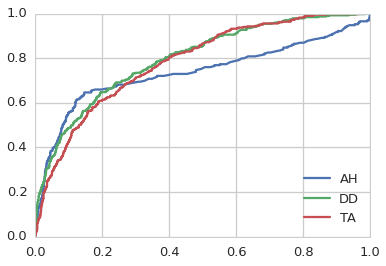

In [269]:
def roc_curves(results):
    fig, ax = plt.subplots()
    for m in moods:
        fpr, tpr, thresh =  metrics.roc_curve(results[m]['y_true'], results[m]['y_prob'])
        ax.plot(fpr, tpr, label=m)
        plt.legend(loc=4)
        
roc_curves(results_cv)